# CDEC Radius Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [7]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [8]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

## Load in the ATL06 SlideRule data:

In [9]:
atl06sr_fn = '../../data/atl06/atl06sr_tuolumne_all_slope_asosnowon_07022022.geojson'
atl06sr_gdf_orig = gpd.read_file(atl06sr_fn)

In [10]:
atl06sr_gdf_orig.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
atl06sr_gdf_orig.time = pd.DatetimeIndex(atl06sr_gdf_orig.time)
atl06sr_gdf_orig = atl06sr_gdf_orig.set_index(['time'])
atl06sr_gdf_orig.sort_index(inplace=True)
atl06sr_gdf_orig['acqdate'] = atl06sr_gdf_orig.index.date
atl06sr_gdf = atl06sr_gdf_orig
atl06sr_col = 'h_mean'
atl06sr_title = 'ICESat-2 ATL06-SR 40m (ground)'
atl06sr_gdf.shape

(149693, 33)

In [12]:
atl06sr_gdf['snow_presence'] = atl06sr_gdf['snow_presence'].astype(int)

## Load a polygon of the study area

In [13]:
outline_gdf = gpd.read_file('../data/UpperTuolRiverBasinOutline.geojson')
outline_gdf = outline_gdf[0:1]
outline_gdf = outline_gdf.to_crs('EPSG:32611')

In [43]:
outline_gdf

,DN,geometry
0,0,"MULTIPOLYGON (((254150.468 4204890.934, 254180..."


In [14]:
outline_snowoff_extent = outline_gdf.total_bounds

## Load CDEC Snow Depth for same date range and add to time series

In [15]:
tum = pd.read_csv('../data/CDEC/TUM_18.csv')
dan = pd.read_csv('../data/CDEC/DAN_18.csv')

tum = tum.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})
dan = dan.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})

In [16]:
tum_elev = 2621.28
dan_elev = 2965

tum_coords = [37.873000,-119.350000]
dan_coords = [37.897000,-119.257000]

In [17]:
# from stack overflow

from datetime import date


def int2date(argdate: int) -> date:
    """
    If you have date as an integer, use this method to obtain a datetime.date object.

    Parameters
    ----------
    argdate : int
      Date as a regular integer value (example: 20160618)

    Returns
    -------
    dateandtime.date
      A date object which corresponds to the given value `argdate`.
    """
    year = int(argdate / 10000)
    month = int((argdate % 10000) / 100)
    day = int(argdate % 100)

    return date(year, month, day)

#### Fill in Nan values so OBS_DATE can be converted to DateTimeIndex  
I found the locations where this column was Nan, and then used the dates on either side to fill in.

In [18]:
tum.loc[126, 'OBS_DATE'] = 20190204.0
tum.loc[134, 'OBS_DATE'] = 20190212.0
tum.loc[394, 'OBS_DATE'] = 20191030.0

#### Convert snow depth from inches to meters, convert time to datetime index, add doy

In [19]:
snwd = pd.DataFrame([tum.OBS_DATE, tum.VALUE]).transpose()
snwd.VALUE = snwd.VALUE * 2.54/100
snwd = snwd.rename(columns={'VALUE':'tum_m'})
snwd['dan_m'] = dan.VALUE * 2.54/100

snwd['Date'] = snwd['OBS_DATE'].map(lambda x: int(x))
snwd['Date'] = pd.DatetimeIndex(snwd['Date'].map(lambda x: int2date(x)))

snwd = snwd.set_index('Date')
snwd.sort_index(inplace=True)
snwd = snwd.drop(columns=['OBS_DATE'])
#add_dowy(snwd)

## Create 20km radius around TUM CDEC site

In [20]:
# Create a transform that will go from the native ICESat-2 and Snotel CS (4326) to the common projection we will use (32610, ie UTM Zone 10 N)

target_crs = "EPSG:32611"
from pyproj import Transformer,CRS
to_target_crs = Transformer.from_crs(4326,target_crs)

In [21]:
# Transform the snotel site locations to 32610
# Originally written by Hannah for Methow notebook

points_cdec = []
cdec_coords = [(37.873000,-119.350000,2621.28),(37.897000,-119.257000,2965)]
for pt in to_target_crs.itransform(cdec_coords):
    points_cdec.append(pt)
x_cdec = [x_tuple[0] for x_tuple in points_cdec]
y_cdec = [y_tuple[1] for y_tuple in points_cdec]
z_cdec = [z_tuple[2] for z_tuple in points_cdec]
cdec_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_cdec, y_cdec))
cdec_gdf['elevation_m'] = z_cdec

<AxesSubplot:>

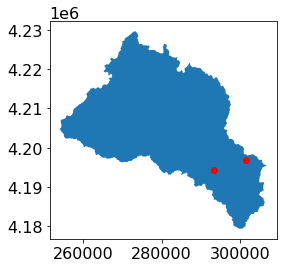

In [48]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')

In [22]:
cdec_gdf['site'] = ''
cdec_gdf['site'][0] = 'tum'
cdec_gdf['site'][1] = 'dan'
cdec_gdf

<ipython-input-22-791d724c5aed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdec_gdf['site'][0] = 'tum'
<ipython-input-22-791d724c5aed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdec_gdf['site'][1] = 'dan'


,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan


In [64]:
cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.x

0    293306.562295
dtype: float64

In [23]:
from shapely.geometry import Point

center = Point((cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.y))

In [71]:
print(center)

POINT (293306.5622950811 4194327.334556827)


In [24]:
df_center= pd.DataFrame({'Location':['center']})
gdf_center = gpd.GeoDataFrame(df_center, geometry=[center], crs=atl06sr_gdf.crs)
gdf_center['geometry'] = gdf_center.geometry.buffer(5000)
gdf_center

,Location,geometry
0,center,"POLYGON ((298306.562 4194327.335, 298282.486 4..."


<AxesSubplot:>

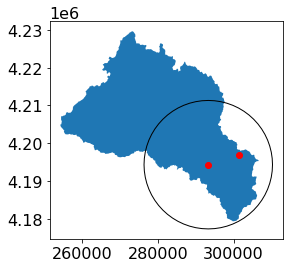

In [82]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')
gdf_center.plot(ax=ax, facecolor='none')

## Clip ATL06 data to the buffer

<AxesSubplot:>

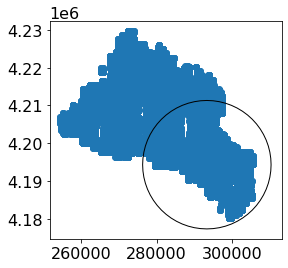

In [88]:
fig, ax = plt.subplots()
atl06sr_gdf.plot(ax=ax)
gdf_center.plot(ax=ax, facecolor='none')

In [84]:
atl06sr_gdf.head(2)

,h_sigma,pflags,segment_id,h_mean,dh_fit_dx,distance,rms_misfit,gt,cycle,delta_time,dh_fit_dy,n_fit_photons,rgt,w_surface_window_final,spot,acqdate,doy,decyear,dowy,snow_presence,platform,site,lidar_z,difference,slope_3m,slope_10m,slope_100m,diff_plus,ASO_snowon,ASO_snowon_date,ASO_snowon_20m,zscore,geometry
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965,0.033182,0,210188,2501.377184,-0.018228,4.215353e+06,0.091912,30,1,2.488094e+07,0.0,15,265,3.0,4,2018-10-15,288,2018.788969,15,0,SlideRule,tuolumne,2501.669922,-0.292738,1.725123,0.962873,NaN,-0.179735,NaN,NaT,NaN,-0.053166,POINT (269304.074 4196719.705)
2018-10-15 23:22:20.021811,0.028329,0,210189,2501.116873,-0.010939,4.215373e+06,0.109110,30,1,2.488094e+07,0.0,18,265,3.0,4,2018-10-15,288,2018.788969,15,0,SlideRule,tuolumne,2501.169922,-0.053049,4.888882,1.995975,NaN,0.059954,NaN,NaT,NaN,-0.036172,POINT (269302.684 4196739.709)


In [86]:
gdf_center

,Location,geometry
0,center,"POLYGON ((310306.562 4194327.335, 310224.703 4..."


In [119]:
#atl06sr_gdf_clip = gpd.clip(atl06sr_gdf, gdf_center)

In [25]:
atl06sr_gdf = gpd.overlay(atl06sr_gdf, gdf_center, how='intersection')

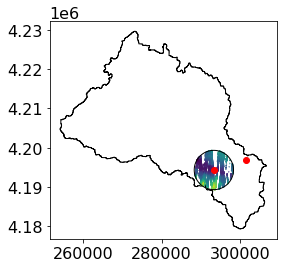

In [26]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax, facecolor='none')
atl06sr_gdf.plot(ax=ax, column='h_mean', c='y', markersize=0.05)
gdf_center.plot(ax=ax, facecolor='none')
cdec_gdf.plot(ax=ax, c='r');

In [27]:
aso_gdf = gpd.read_file('../../data/aso_dates.geojson')

In [28]:
aso_gdf.date = pd.DatetimeIndex(aso_gdf.date)
aso_gdf = aso_gdf.set_index(['date'])
aso_gdf.sort_index(inplace=True)
aso_gdf['acqdate'] = aso_gdf.index.date

In [133]:
aso_gdf.head(2)

,fn,platform,doy,decyear,dowy,acqdate,site,geometry
date,,,,,,,,
2019-03-24,../../data/lidar/tuolumne/snow_on/raw/ASO_3M_S...,ASO,83,2019.224658,175,2019-03-24,tuolumne,"POLYGON ((242715.000 4234848.000, 242715.000 4..."
2019-04-17,../../data/lidar/tuolumne/snow_on/raw/ASO_3M_S...,ASO,107,2019.290411,199,2019-04-17,tuolumne,"POLYGON ((254694.878 4234848.000, 254694.878 4..."


In [29]:
df_list = [aso_gdf, atl06sr_gdf]

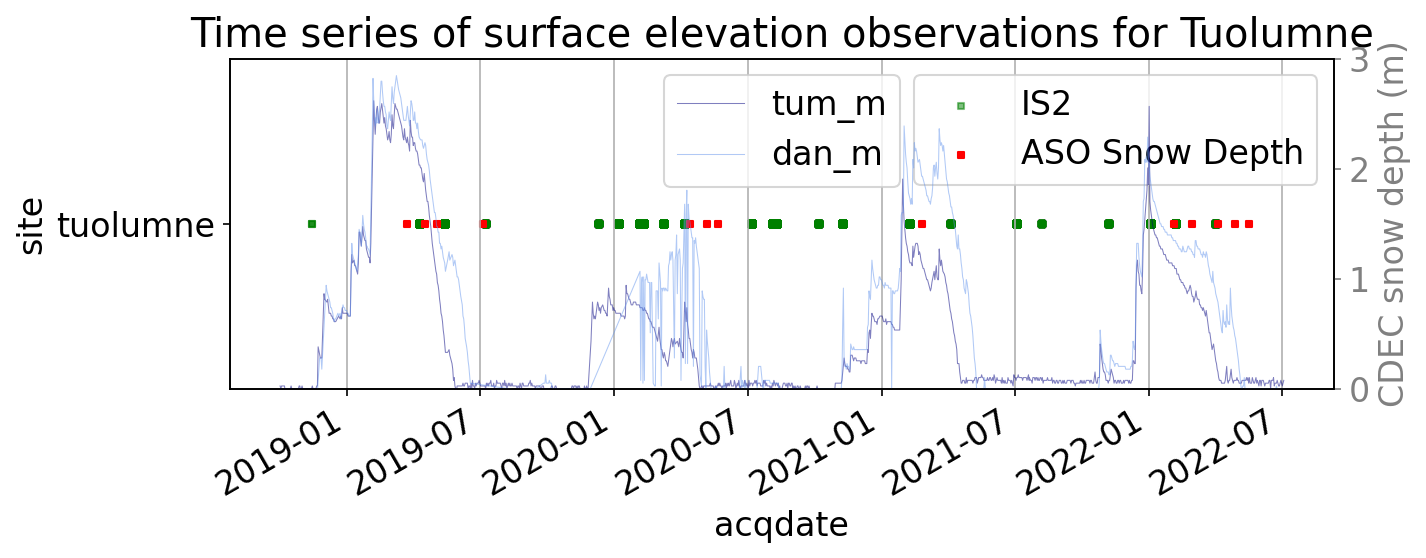

In [30]:
f, ax = plt.subplots(figsize=(10,4), dpi=150)
mykw = {'s':10, 'marker':'s', 'kind':'scatter'}

pd.DataFrame(df_list[1].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='g', label='IS2', **mykw)
pd.DataFrame(df_list[0].drop(columns='geometry')).plot(ax=ax, x='acqdate', y='site', color='r', label='ASO Snow Depth', **mykw)

ax1 = ax.twinx()
snwd[snwd['tum_m'] < 2.9]['tum_m'].plot(ax=ax1, alpha=0.5, color='navy', lw=0.5, style='-')
snwd[snwd['dan_m'] < 2.9]['dan_m'].plot(ax=ax1, alpha=0.5, color='cornflowerblue', lw=0.5, style='-')
ax1.set_ylabel('CDEC snow depth (m)', color='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylim(0,3)
plt.legend(loc='best')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()
ax.grid(axis='x', which='major')
ax.set_title('Time series of surface elevation observations for Tuolumne')
plt.tight_layout()

In [31]:
atl06sr_gdf[atl06sr_gdf['snow_presence']==0]['difference'].describe()

count    5178.000000
mean       -0.071037
std         1.326416
min        -9.165172
25%        -0.463374
50%        -0.147880
75%         0.232288
max        68.208479
Name: difference, dtype: float64

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [32]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus'] - atl06sr_gdf['diff_plus'].mean()) / atl06sr_gdf['diff_plus'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [33]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [172]:
atl06sr_gdf[atl06_idx]['diff_plus'].describe()

count    70169.000000
mean         0.630709
std          1.246569
min         -3.979930
25%         -0.085577
50%          0.588739
75%          1.317058
max          4.998049
Name: diff_plus, dtype: float64

In [173]:
atl06sr_gdf[inner_snowoff_idx]['diff_plus'].describe()

count    21693.000000
mean         0.018235
std          1.097786
min         -3.971239
25%         -0.497158
50%         -0.024106
75%          0.527572
max          4.998049
Name: diff_plus, dtype: float64

In [174]:
atl06sr_gdf[inner_snowon_idx]['diff_plus'].describe()

count    48476.000000
mean         0.904790
std          1.211221
min         -3.979930
25%          0.276878
50%          0.848356
75%          1.571027
max          4.989915
Name: diff_plus, dtype: float64

In [34]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [35]:
mpl_epoch = '1970-01-01'
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-05-01'

In [43]:
def boxplot_date(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', clim=(-5, 5), name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_width = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_width = 20*bp_width/bp_width.max()+5
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_width2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_width2 = 20*bp_width2/bp_width2.max()+5
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'c':'black'},  medianprops={'c':'green', 'lw':2},widths=bp_width)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1, 'c':'magenta'}, medianprops={'c':'orange', 'lw':2}, widths=bp_width2)
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=2)
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=2)
    
    #cso['depth_m'].plot(ax=ax, linestyle='none', marker='.', color='k', markersize=5)
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Elevation difference (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    plt.title('5 km Radius')
    
    plt.tight_layout()
    plt.savefig(name, dpi=500)

In [37]:
atl06sr_gdf[atl06sr_gdf['snow_presence'] == 0]['difference'].describe()

count    5178.000000
mean       -0.071037
std         1.326416
min        -9.165172
25%        -0.463374
50%        -0.147880
75%         0.232288
max        68.208479
Name: difference, dtype: float64

In [38]:
type(atl06sr_gdf['snow_presence'][0])

numpy.int64

In [39]:
atl06sr_gdf.head(2)

,h_sigma,pflags,segment_id,h_mean,dh_fit_dx,distance,rms_misfit,gt,cycle,delta_time,dh_fit_dy,n_fit_photons,rgt,w_surface_window_final,spot,acqdate,doy,decyear,dowy,snow_presence,platform,site,lidar_z,difference,slope_3m,slope_10m,slope_100m,diff_plus,ASO_snowon,ASO_snowon_date,ASO_snowon_20m,zscore,Location,geometry
0,0.054840,0,210125,2587.444770,-0.018003,4.214081e+06,0.153952,40,1,2.738152e+07,0.0,68,707,3.0,3,2018-11-13,317,2018.868262,44,0,SlideRule,tuolumne,2588.691895,-1.247125,10.612905,2.909689,0.27292,-1.134122,NaN,NaT,NaN,-1.438406,center,POINT (292318.567 4194846.152)
1,0.013356,0,210126,2587.231692,-0.002520,4.214101e+06,0.146350,40,1,2.738152e+07,0.0,139,707,3.0,3,2018-11-13,317,2018.868262,44,0,SlideRule,tuolumne,2587.623047,-0.391355,0.202440,1.130302,0.27292,-0.278352,NaN,NaT,NaN,-0.767890,center,POINT (292317.156 4194866.152)


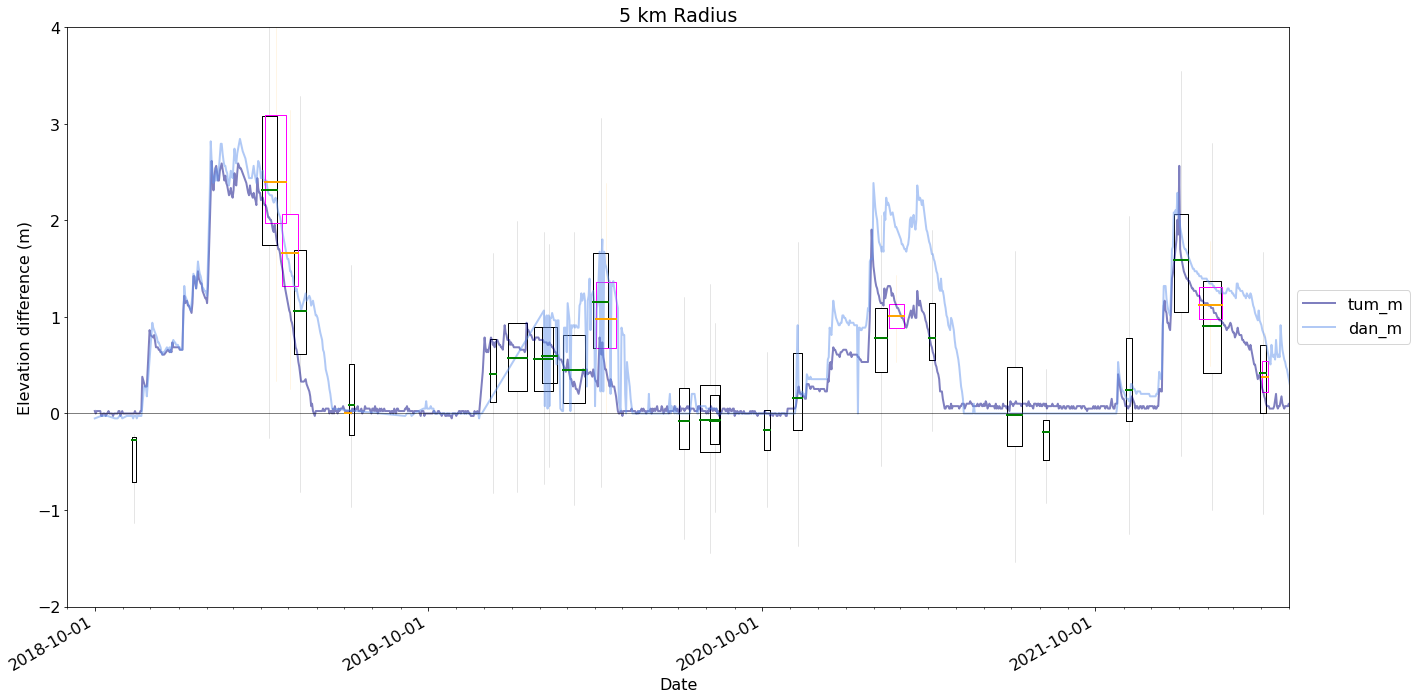

In [44]:
boxplot_date(atl06sr_gdf, 'diff_plus', 'ASO_snowon', clim=(-2,4), name = '../figures/boxplots_cdec_aso_radius5.jpeg')

In [185]:
    bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
    bp_alpha = (bp_alpha/bp_alpha.max())

In [186]:
bp_alpha

array([0.00300566, 0.01078501, 0.42043847, 0.50760255, 0.06859972,
       0.05410184, 0.00141443, 0.17821782, 0.01485149, 0.18882603,
       0.18528996, 0.61863508, 1.        , 0.78306223, 0.71605375,
       0.9635785 , 0.02298444, 0.68369873, 0.68917963, 0.7342645 ,
       0.19589816, 0.07072136, 0.58062235, 0.03200141, 0.01679632,
       0.89639321, 0.09052334, 0.13967468, 0.0208628 , 0.06859972,
       0.71799859, 0.02333805, 0.16743281, 0.00671853, 0.11032532,
       0.62535361, 0.86898868, 0.1039604 ])

In [199]:
len(bp_alpha)

38

In [202]:
len(atl06sr_gdf['acqdate'].unique())

38

In [ ]:
def scatter(x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)

In [194]:
def boxplot_date(df, col, groupby_col='acqdate', clim=(-5, 5), name='../figures/boxplots_cdec.jpeg'):
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
    bp_alpha = (bp_alpha/bp_alpha.max())
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    f, ax = plt.subplots(figsize=(20,10))
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2},\
                   boxprops= {'lw':1, 'c':'k','alpha':(lambda x:x in by_alpha)}, medianprops={'c':'orange', 'lw':2, 'alpha':(lambda x:x in by_alpha)})
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=2)
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=2)
    
    #cso['depth_m'].plot(ax=ax, linestyle='none', marker='.', color='k', markersize=5)
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Elevation difference (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()

TypeError: alpha must be numeric or None, not <class 'function'>

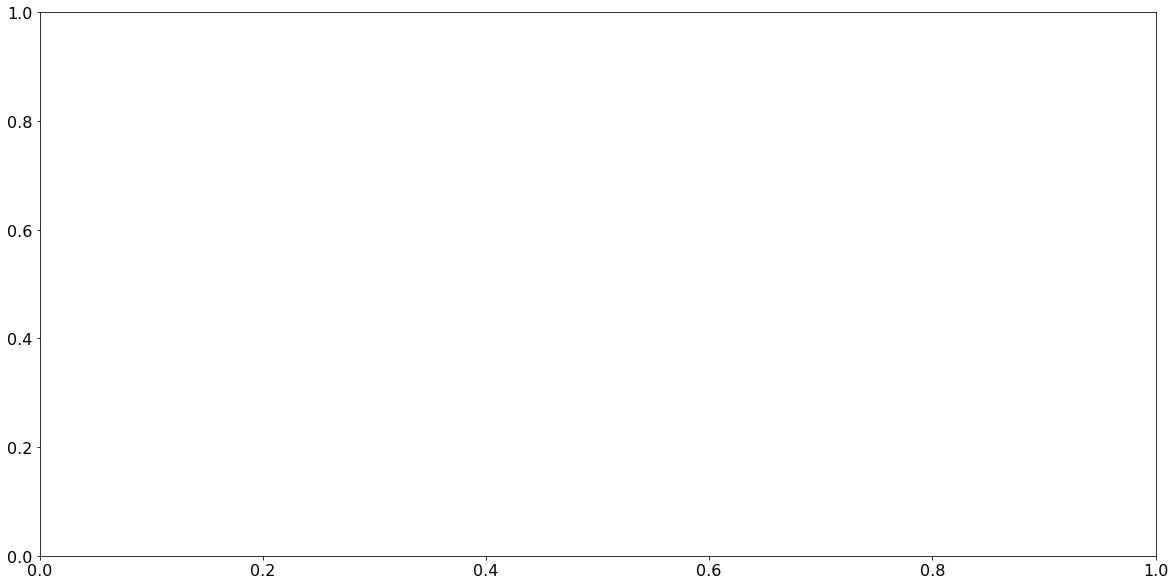

In [195]:
boxplot_date(atl06sr_gdf, 'diff_plus', clim=(-2,4), name = '../figures/boxplots_cdec_aso_radius17.jpeg')